In [1]:
import time
import math
import os
import torch
import torch.nn as nn
import torch.onnx
import numpy as np

import pandas as pd

from sklearn.decomposition import PCA
import pickle
import json

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.cluster import KMeans

In [17]:
from numpy import linalg as LA
from sklearn.manifold import TSNE

In [3]:
def load_doc(filename):
    file = open(filename, 'r', encoding='utf-8-sig')
    text = file.read()
    file.close()
    return text

In [4]:
def load_emb(glove_file, fullLoad=False, n_vecs=20000):
    """ Loads glove vectors from a file """
    tok2vec = {}
    with open(glove_file, 'r') as glove_fh:
        for i, row in enumerate(glove_fh):
            word, vec = row.split(' ', 1)
            tok2vec[word] = np.array([float(n) for n in vec.split(' ')])
            if (not fullLoad and i+1 >= n_vecs):
                break
    return tok2vec

In [5]:
def normalizeEmb(emb):
    for k in emb.keys():
        emb[k] = emb[k]/LA.norm(emb[k])
    return emb

In [6]:
def removeProtectedAttribute(emb):
    emb = {}
    for w in gnglove:
        emb[w] = gnglove[w][:299]
    return emb

In [7]:
def clusterPerformanceGlove(glove_vecs,words,labels,verbose = False):
    words_labels = [(w,l) for w,l in zip(words,labels) if w in glove_vecs ]
    words = [w for w,l in words_labels]
    labels = [l for w,l in words_labels]
    vectors = [glove_vecs[o] for o in words] 
    #print(vectors.shape)
    accuracy = []
    for i in range(10):
        kmeans = KMeans(n_clusters=2)
        kmeans.fit(vectors)
        p = sum(kmeans.labels_ == labels)/ len(labels)
        accuracy.append(max(p,1-p))
    if verbose:
        if p > 1-p:
            print([w for w,l,tl in zip(words,kmeans.labels_,labels) if l!=tl])
        else:
            print([w for w,l,tl in zip(words,kmeans.labels_,labels) if l==tl])
    return np.mean(accuracy)

In [8]:
maleBiasWords = load_doc('gloveMaleBiasedWords.txt').split('\n')
len(maleBiasWords)

500

In [9]:
femaleBiasWords = load_doc('gloveFemaleBiasedWords.txt').split('\n')
len(femaleBiasWords)

500

In [10]:
words = femaleBiasWords + maleBiasWords
labels = [0 for w in femaleBiasWords] + [1 for w in maleBiasWords]

In [11]:
glove_file = '/scratch/um367/EMB/embeddings/wiki_glove.txt'
glove = load_emb(glove_file, fullLoad=False, n_vecs=50000)
len(glove)

50000

In [12]:
glove = normalizeEmb(glove)

In [13]:
clusterPerformanceGlove(glove,words,labels,verbose = False)

1.0

In [28]:
vectors = [glove[w] for w in words]
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(vectors)

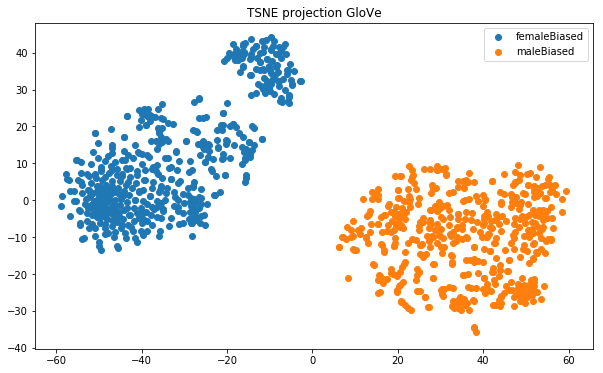

In [30]:
plt.figure(figsize=(10, 6)) 
plt.scatter(new_values[:len(femaleBiasWords),0],new_values[:len(femaleBiasWords),1],label = 'femaleBiased')
plt.scatter(new_values[len(femaleBiasWords):,0],new_values[len(femaleBiasWords):,1],label ='maleBiased')
plt.legend()
_= plt.title('TSNE projection GloVe')

In [14]:
gnglove_file = '/scratch/um367/EMB/embeddings/wiki_gnglove.txt'
gnglove = load_emb(gnglove_file, fullLoad=False, n_vecs=50000)
len(gnglove)

50000

In [15]:
gnglove = normalizeEmb(gnglove)
gnglove = removeProtectedAttribute(gnglove)

In [16]:
clusterPerformanceGlove(gnglove,words,labels,verbose = False)

0.8577999999999999

In [18]:
vectors = [gnglove[w] for w in words]
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(vectors)

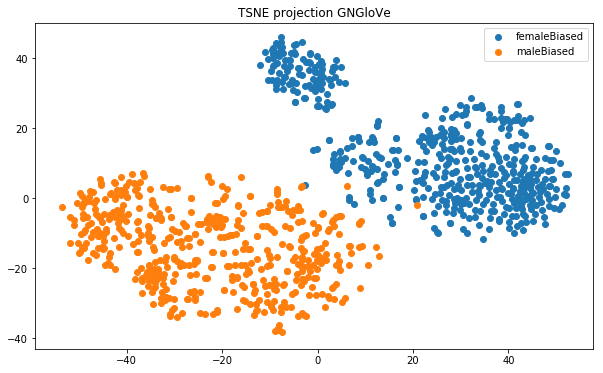

In [27]:
plt.figure(figsize=(10, 6)) 
plt.scatter(new_values[:len(femaleBiasWords),0],new_values[:len(femaleBiasWords),1],label = 'femaleBiased')
plt.scatter(new_values[len(femaleBiasWords):,0],new_values[len(femaleBiasWords):,1],label ='maleBiased')
plt.legend()
_= plt.title('TSNE projection GNGloVe')